# Hierarchical Multinomial Logit (HMNL) with Liesel and NUTS

This notebook demonstrates the implementation of a Hierarchical Multinomial Logit model using the **Liesel** library and **JAX**.

**Key Components:**
* **Data Generation:** Simulates synthetic choice data for multiple individuals (units) choosing between different alternatives.
* **Model Specification:** Defines a Bayesian hierarchical model where individual preferences ($\beta$) are drawn from a unit-level ("per person")distribution.
* **Inference:** Uses the No-U-Turn Sampler (NUTS) via `liesel.goose` to estimate posterior distributions.
* **Analysis:** visualizes parameter recovery and convergence (trace plots).

**Model Structure:**
* $U_{ij} = X_{ij} \beta_i + \epsilon_{ij}$ (Utility of alternative $j$ for individual $i$)
* $\beta_i \sim \mathcal{N}(\mu, \Sigma)$ (Heterogeneity across individuals)

In [1]:
import jax
import jax.numpy as jnp

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import liesel.model as lsl
import liesel.goose as gs
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb

# Set random seed for reproducibility
key = jax.random.PRNGKey(42)

## Utility Distributions

We define a custom `InverseWishart` distribution class. In hierarchical models, the Inverse-Wishart distribution is commonly used as a conjugate prior for the covariance matrix of a multivariate normal distribution. This helps in modeling the correlation between random effects (the $\beta$ coefficients). Unofrtunately it is not implemente as a tfd object. Therefore, a custom class is designed, which uses the tfd.WishartTriL class (Wishart distribution with lower Triangular Cholesky matix) and uses chained bijectors.

In [2]:
class InverseWishart(tfd.TransformedDistribution):
    """
    Inverse Wishart distribution over positive definite matrices.
    
    If W ~ Wishart(df, Psi^{-1}), then Sigma = W^{-1} ~ InverseWishart(df, Psi).
    
    Args:
        df: Degrees of freedom (must be > dimension - 1).
        scale: Scale matrix (Psi), must be positive definite and symmetric.
    """
    
    def __init__(self, df, scale, **kwargs):
        # Store parameters
        self._df = jnp.asarray(df)
        self._scale = jnp.asarray(scale)
        
        # Compute Wishart scale (inverse of IW scale)
        wishart_scale_tril = jnp.linalg.cholesky(jnp.linalg.inv(self._scale))
        
        # Base Wishart distribution
        base_dist = tfd.WishartTriL(df=self._df, scale_tril=wishart_scale_tril)
        
        # Transformation: Wishart Cholesky → Inverse Wishart full matrix
        bijector = tfb.Chain([
            tfb.CholeskyOuterProduct(),
            tfb.CholeskyToInvCholesky(),
            tfb.Invert(tfb.CholeskyOuterProduct())
        ])
        
        # Initialize parent class
        super().__init__(
            distribution=base_dist,
            bijector=bijector,
            **kwargs
        )
        
        # Override parameters for serialization
        self._parameters = dict(df=self._df, scale=self._scale)
    
    @property
    def df(self):
        """Degrees of freedom parameter."""
        return self._df
    
    @property
    def scale(self):
        """Scale matrix parameter."""
        return self._scale

## 3. Synthetic Data Generation

Here we simulate the dataset to test the model. This is taken from Rossi et al. (2006) page 318.

We generate data for:
* **N Units:** Distinct decision-makers
* **J Alternatives:** The options available for each choice
* **K Covariates:** The features describing the alternatives (in this case only 1 covariate that simulates log-price)

We simulate "True" Beta parameters for each individual and use them to generate discrete choices ($y$) based on the utility maximization principle.

In [3]:
def simulate_data(seed):

    # Genearte seed and split into sub-keys
    key = jax.random.PRNGKey(seed)
    k1, k2, k3 = jax.random.split(key, 3)
    
    # --- Parameters from Rossi et al. ---
    n_units = 100
    n_obs_small = 5
    n_obs_large = 50
    n_alts = 5
    n_params = 5 # 4 intercepts + 1 slope
    
    # Units setup: 50 with 5 obs, 50 with 50 obs
    counts = jnp.array([n_obs_small] * 50 + [n_obs_large] * 50)
    unit_idx = jnp.repeat(jnp.arange(n_units), counts)              # Mapping obs -> unit
    
    # True Hyperparameters for beta_i prior
    # mu = (1, -1, 0, 0, -3)
    true_mu = jnp.array([1.0, -1.0, 0.0, 0.0, -3.0])
    
    # V_beta (Sigma): Diagonal=3, (4,5) and (5,4)=1.5 #
    # adapted for python indices (3,4)
    true_Sigma = 3.0 * jnp.eye(n_params)
    true_Sigma = true_Sigma.at[3, 4].set(1.5)
    true_Sigma = true_Sigma.at[4, 3].set(1.5)
    
    # Generate Unit Level Bet as
    # beta_i ~ N(mu, Sigma)
    beta_dist = tfd.MultivariateNormalFullCovariance(loc=true_mu, covariance_matrix=true_Sigma)
    betas = beta_dist.sample(seed=k1, sample_shape=(n_units,))
    
    # --- Generate X and Choices ---
    # X ~ Uniform(-1.5, 0)
    # Structure: We need a design matrix for MNL.
    # Utilities: U_j = alpha_j + beta * price_j
    # Design Matrix shape per choice task: (5 alternatives, 5 parameters)
    # Cols 0-3: Intercept dummies (Alt 5 is base)
    # Col 4: Price variable
    
    X_list = []
    y_list = []
    
    for i in range(n_units):
        n_i = counts[i]
        beta_i = betas[i]
        
        # Generate Price X for this unit's observations
        # Shape: (n_i, n_alts)
        k2, sk = jax.random.split(k2)
        price = jax.random.uniform(sk, shape=(n_i, n_alts), minval=-1.5, maxval=0.0)
        
        # Build Design Matrix D: (n_i, n_alts, n_params)
        D = jnp.zeros((n_i, n_alts, n_params))
        
        # Set intercepts for first 4 alternatives
        for a in range(4):
            D = D.at[:, a, a].set(1.0)
            
        # Set price slope (column 4) for all alternatives
        D = D.at[:, :, 4].set(price)
        
        # Calculate Utility: V = D @ beta
        # (n_i, 5, 5) @ (5,) -> (n_i, 5)
        V = jnp.einsum('ijk,k->ij', D, beta_i)
        
        # Probabilities (Softmax)
        probs = jax.nn.softmax(V, axis=1)
        
        # Sample Choices
        k3, sk = jax.random.split(k3)
        choices = tfd.Categorical(probs=probs).sample(seed=sk)
        
        X_list.append(D)
        y_list.append(choices)
        
    X_data = jnp.concatenate(X_list, axis=0)
    y_data = jnp.concatenate(y_list, axis=0)
    
    return {
        "X": X_data,
        "y": y_data,
        "unit_idx": unit_idx,
        "counts": counts,
        "true_mu": true_mu,
        "true_Sigma": true_Sigma,
        "true_betas": betas
    }

data = simulate_data(42)
print("Total Observations:", data["y"].shape)

Total Observations: (2750,)


## 4. Model Specification with Liesel

We use `liesel.model` to build the probabilistic graphical model.

* **Priors:** We assign priors to the population mean ($\mu$) and the covariance matrix ($\Sigma$).
* **Random Effects:** The individual-level coefficients `beta_unit` are centered around the population mean.
* **Likelihood:** The observed choices are modeled using a Categorical distribution (via the softmax of utilities).

liesel.model.viz - WARNING - Graphviz not found in PATH. Using fallback graph layout. Consider installing Graphviz: https://graphviz.org/download


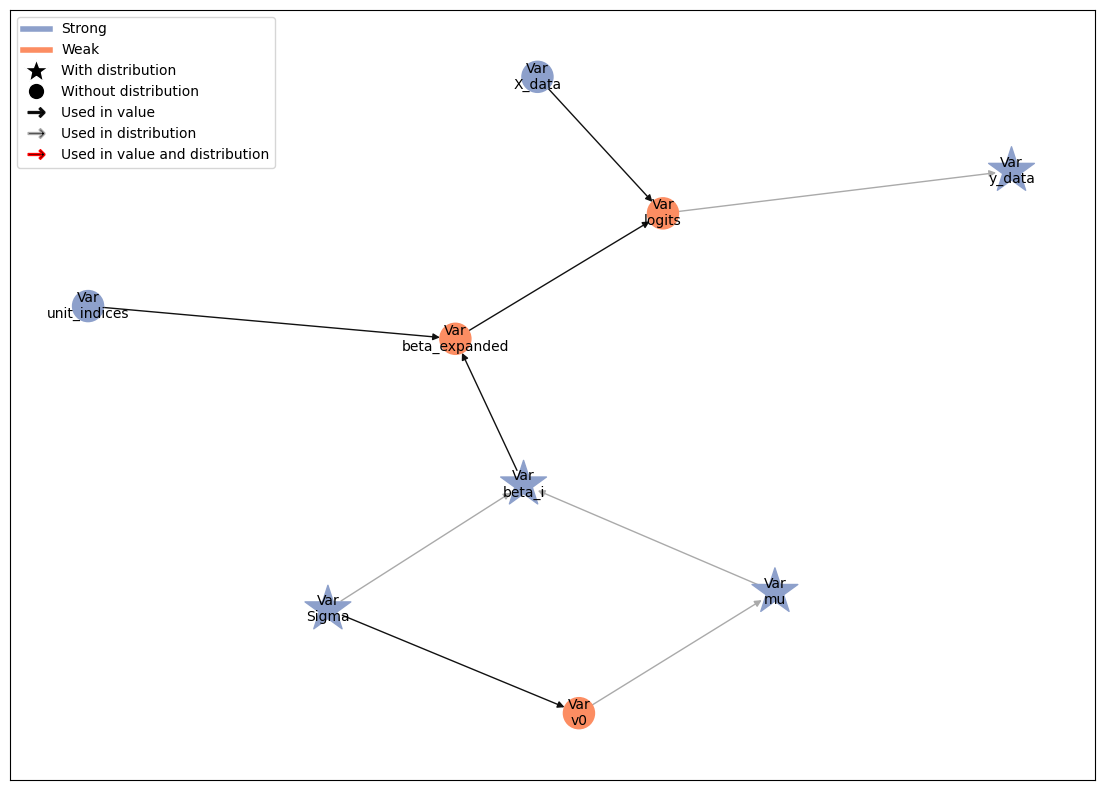

In [4]:
# Prior parameters (Diffuse per Rossi)
k_dim = 5
nu = k_dim + 3
V = nu * jnp.eye(k_dim)
A = 0.01                    # Precision scaling for mu

# --- Define Variables for Hyperparameters ---

# Sigma (V_beta)
# We use the custom InverseWishart 
Sigma_prior_dist = lsl.Dist(InverseWishart, df=float(nu), scale=V)
Sigma = lsl.Var.new_param(jnp.eye(k_dim), distribution=Sigma_prior_dist, name="Sigma")

# Mu
########################################################################################
## This is still very questionable, since mu(beta_i) is simply a null vector in Rossi ##
########################################################################################
# Rossi specifies vec(mu | Sigma) ~ N(mu_bar, Sigma (x) A^-1). 
# Since A is scalar, this is N(mu_bar, Sigma / A).
mu_prior_dist = lsl.Dist(
    tfd.MultivariateNormalFullCovariance,
    loc=jnp.zeros(k_dim),
    covariance_matrix=lsl.Var.new_calc(lambda s: s / A, s=Sigma)
)
mu = lsl.Var.new_param(jnp.zeros(k_dim), distribution=mu_prior_dist, name="mu")

# 3. Define Unit-Level Parameters (Beta_i)
# beta_i ~ N(mu, Sigma)
beta_dist = lsl.Dist(
    tfd.MultivariateNormalFullCovariance,
    loc=mu,
    covariance_matrix=Sigma
)

# Initial value for betas: (100 units, 5 params)
n_units = 100
beta_i = lsl.Var.new_param(
    jnp.zeros((n_units, k_dim)), 
    distribution=beta_dist, 
    name="beta_i"
)

# 4. Define Likelihood Logic
# Data Inputs (Predictors and Indices)
X_var = lsl.Var.new_obs(data["X"], name="X_data")
idx_var = lsl.Var.new_obs(data["unit_idx"], name="unit_indices")

# Compute Logits
# We need to pick the correct beta_i for each observation based on unit_idx
# This operation broadcasts the 100 betas to the total observations
beta_expanded = lsl.Var.new_calc(
    lambda b, idx: b[idx], 
    b=beta_i, 
    idx=idx_var, 
    name="beta_expanded"
)

# MNL Utility Calculation: X * beta
# X: (N_obs, 5_alts, 5_params)
# beta: (N_obs, 5_params) -> (N_obs, 5_params, 1) via einsum or reshape
# Result: (N_obs, 5_alts)
logits = lsl.Var.new_calc(
    lambda x, b: jnp.einsum("nij,nj->ni", x, b),
    x=X_var,
    b=beta_expanded,
    name="logits"
)

# Likelihood Distribution
likelihood_dist = lsl.Dist(tfd.Categorical, logits=logits)

# 5. Define Observed Outcome (y)
# FIX: Pass the distribution directly to the constructor
y_var = lsl.Var.new_obs(
    data["y"], 
    distribution=likelihood_dist, 
    name="y_data"
)

# 6. Assemble Model
model = lsl.Model([y_var])

# FIX: Use the method on the model object instead of the module function
model.plot_vars()

In [5]:
# Create Interface
interface = gs.LieselInterface(model)

# Setup Builder ()
eb = gs.EngineBuilder(seed=100, num_chains=4)

eb.set_model(interface)
eb.set_initial_values(model.state)

# Add Kernels
# Use NUTS for Hyperparameters (not applied druing time of Rossi paper(2006), but works well)
eb.add_kernel(gs.NUTSKernel(["mu"]))                                
eb.add_kernel(gs.NUTSKernel(["Sigma"]))                             # seems to still missbehave

# NUTS for Unit-Level Betas (500 latent parameters)
eb.add_kernel(gs.NUTSKernel(["beta_i"]))

# Set samplig duration and parameters 
eb.set_duration(warmup_duration=500, posterior_duration=2000, thinning_posterior=1)

# 5. Build
engine = eb.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [6]:
# Cell 6: Run Sampling
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
100%|██████████████████████████████████████████| 3/3 [00:24<00:00,  8.28s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 2, 3, 2 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 64, 65, 57, 57 / 75 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 2, 2, 1, 2 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 328.68chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 3, 1, 2, 1 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 21, 23, 22, 20 / 25 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 1, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished ep

# Model Diagnostics

In [7]:
# Extract Results
results = engine.get_results()
samples = results.get_posterior_samples()

# Create summary for numerical diagnostics 
summary = gs.Summary(results)
# display(summary)
# (R-hat < 1.05 indicates convergence)

In [8]:
def plot_detailed_param(results_dict, param_name, param_indices):
    """
    Plot detailed diagnostics for a parameter.
    param_indices can be a single int or list of ints.
    """
    if isinstance(param_indices, int):
        param_indices = [param_indices]
    for idx in param_indices:
        print(f"--- Detailed Diagnostics: {param_name}[{idx}] ---")
        gs.plot_param(results_dict, param_name, param_index=idx)
        plt.show()

1. CONVERGENCE DIAGNOSTICS

--- 1.1: Global Mu Trace Plots ---


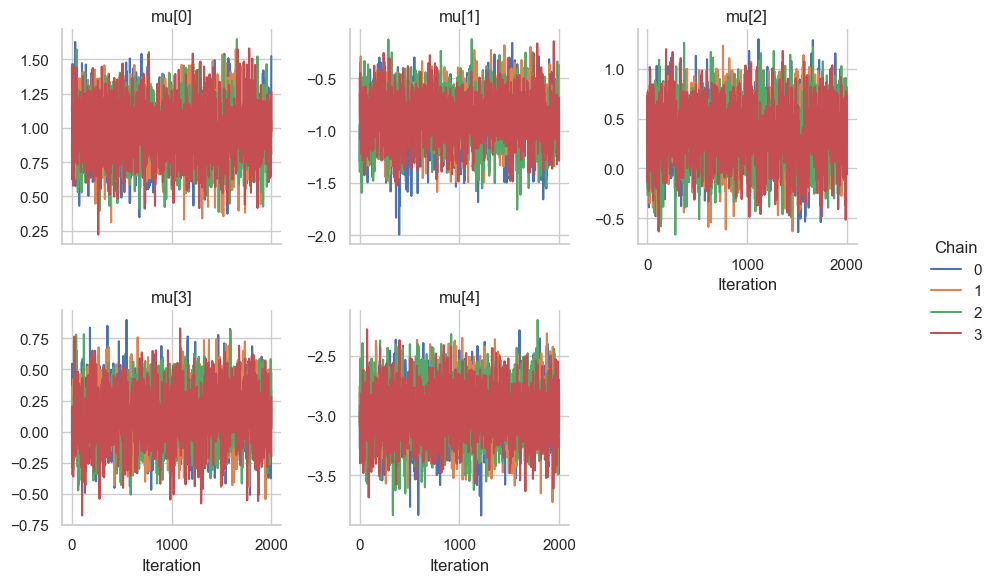


--- 1.2: Detailed Mu Parameter Diagnostics ---
--- Detailed Diagnostics: mu[0] ---


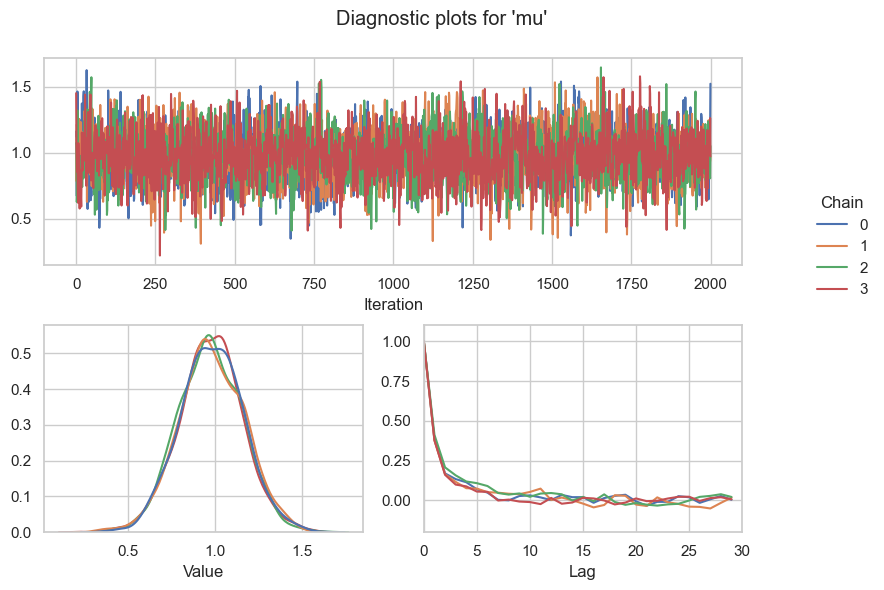

--- Detailed Diagnostics: mu[1] ---


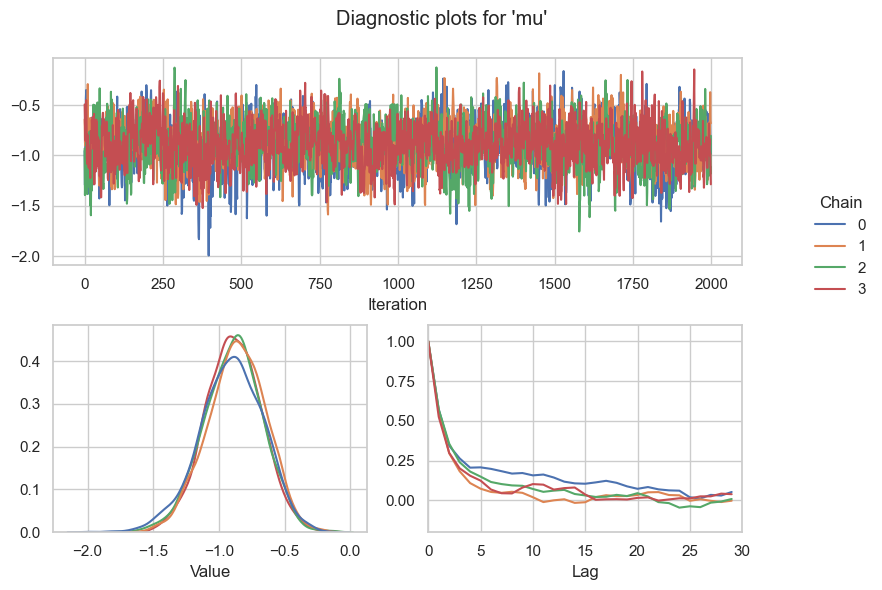

--- Detailed Diagnostics: mu[2] ---


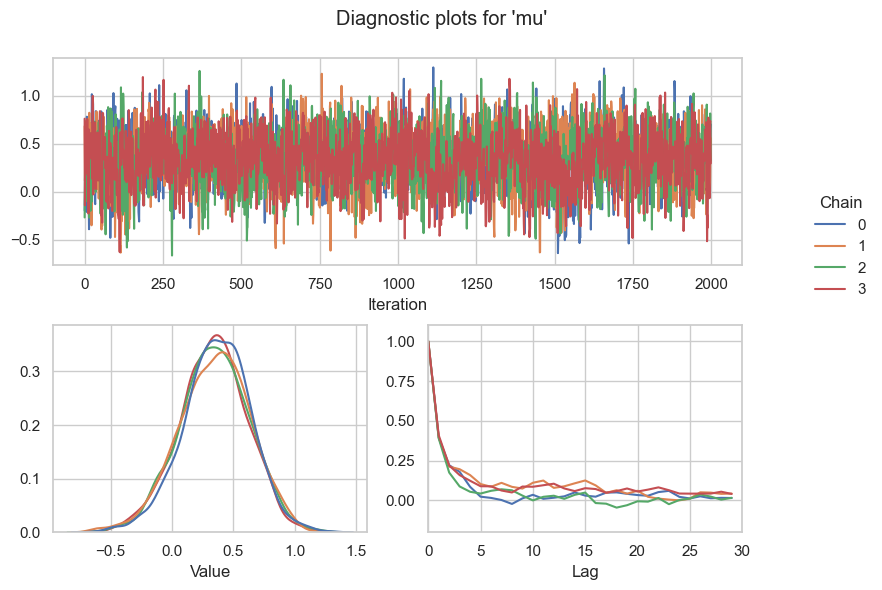

--- Detailed Diagnostics: mu[3] ---


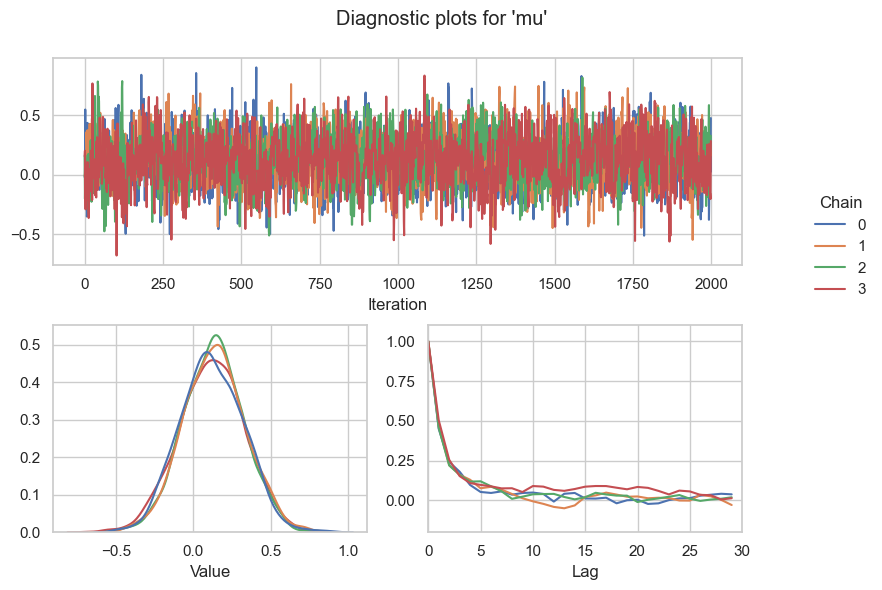

--- Detailed Diagnostics: mu[4] ---


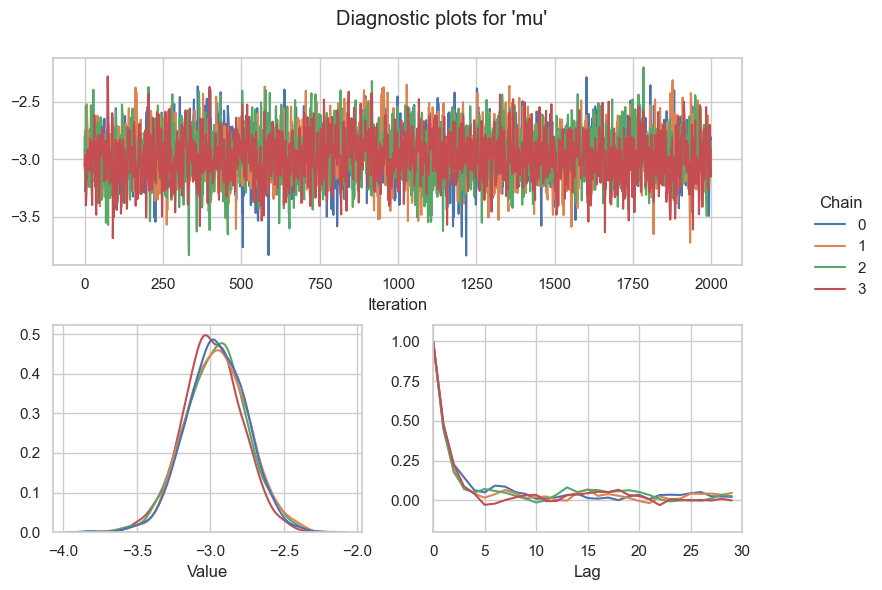


--- 1.3: Sigma Covariance Matrix Diagnostics ---
Trace Plot: Sigma[0,0] (Variance of Intercept)


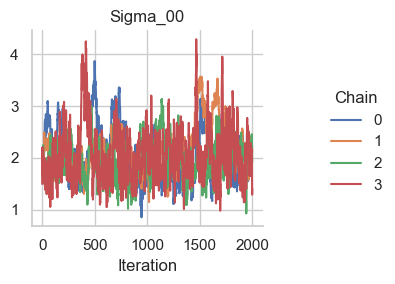

Trace Plot: Sigma[4,4] (Variance of Price Slope)


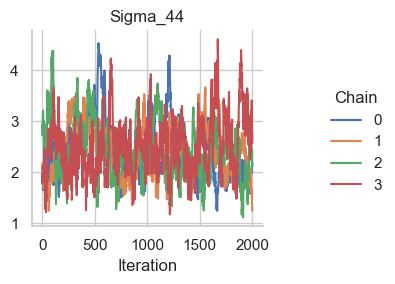

In [9]:
# ==============================================================================
# 1. CONVERGENCE DIAGNOSTICS (Trace Plots & Chain Diagnostics)
# ==============================================================================
print("=" * 80)
print("1. CONVERGENCE DIAGNOSTICS")
print("=" * 80)

# --- 1.1 Global mu Diagnostics ---
print("\n--- 1.1: Global Mu Trace Plots ---")
gs.plot_trace(results, "mu")
plt.show()

print("\n--- 1.2: Detailed Mu Parameter Diagnostics ---")
plot_detailed_param(results, "mu", param_indices=range(5))
plt.show()

# --- 1.2 Sigma Diagnostics ---
print("\n--- 1.3: Sigma Covariance Matrix Diagnostics ---")
# Extract diagonal elements from 4D Sigma array
sigma_00_trace = samples["Sigma"][..., 0, 0]  # Variance of intercept
sigma_44_trace = samples["Sigma"][..., 4, 4]  # Variance of price slope

temp_results_sigma = {
    "Sigma_00": sigma_00_trace,
    "Sigma_44": sigma_44_trace
}

print("Trace Plot: Sigma[0,0] (Variance of Intercept)")
gs.plot_trace(temp_results_sigma, "Sigma_00")
plt.show()

print("Trace Plot: Sigma[4,4] (Variance of Price Slope)")
gs.plot_trace(temp_results_sigma, "Sigma_44")
plt.show()

In [10]:
# ==============================================================================
# 2. POSTERIOR SUMMARY STATISTICS
# ==============================================================================
print("\n" + "=" * 80)
print("2. POSTERIOR SUMMARY STATISTICS")
print("=" * 80)

# Extract information about beta_i samples
chains, samples_num, n_units, n_params = samples["beta_i"].shape

# --- 2.1 Beta_i Summary Statistics ---
print("\n--- 2.1: Beta_i (Unit-Level Parameters) Summary ---")
beta_posterior_means = jnp.mean(samples["beta_i"], axis=(0, 1))  # (units, parameters)
beta_posterior_stds = jnp.std(samples["beta_i"], axis=(0, 1))    # (units, parameters)

print(f"Shape: {beta_posterior_means.shape} (units x parameters)")
print("\nPosterior Means:")
print(beta_posterior_means)
print("\nPosterior Std Dev:")
print(beta_posterior_stds)

# --- 2.2 Mu Summary Statistics ---
print("\n--- 2.2: Mu (Global Parameters) Summary ---")
mu_posterior_means = jnp.mean(samples["mu"], axis=(0, 1))  # (units, params)
mu_posterior_stds = jnp.std(samples["mu"], axis=(0, 1))

print(f"Shape: {mu_posterior_means.shape}")
print("\nPosterior Means:")
print(mu_posterior_means)
print("\nPosterior Std Dev:")
print(mu_posterior_stds)


2. POSTERIOR SUMMARY STATISTICS

--- 2.1: Beta_i (Unit-Level Parameters) Summary ---
Shape: (100, 5) (units x parameters)

Posterior Means:
[[ 0.14457567 -1.1828365   1.4738026  -0.44691467 -3.6312757 ]
 [ 0.64469093  0.37301657 -0.78885376 -1.3226707  -4.405699  ]
 [ 0.4693289  -0.5465334   1.5704641   0.46063527 -3.595274  ]
 [ 0.3645724  -0.88449514 -2.0334342  -1.127003   -3.7195632 ]
 [-0.4568494  -0.8533739  -1.6560589   1.3412769  -2.0458605 ]
 [ 1.5216693   0.07460091  0.15769072 -0.7063008  -3.598999  ]
 [ 1.1185433  -0.14484183  1.7004113  -0.6240779  -3.436103  ]
 [ 2.3379047  -1.3912872   0.5122759  -0.78912485 -2.5103683 ]
 [ 0.96900445 -1.3168681  -1.1009723   2.1457407  -2.096833  ]
 [ 2.5432038  -1.4970218  -0.9759461   0.23583211 -1.891157  ]
 [-0.14132705 -1.5584129  -1.3652129   2.7445214  -1.7040963 ]
 [ 2.2730837  -1.3653787  -0.6293832   0.03635095 -2.866386  ]
 [ 2.1278648   0.78837866  0.42937544 -0.6546902  -2.575335  ]
 [ 0.9977229  -1.320361    2.7332668   0


3. PARAMETER RECOVERY

--- 3.1: Unit-Level Parameter Recovery (All Parameters) ---


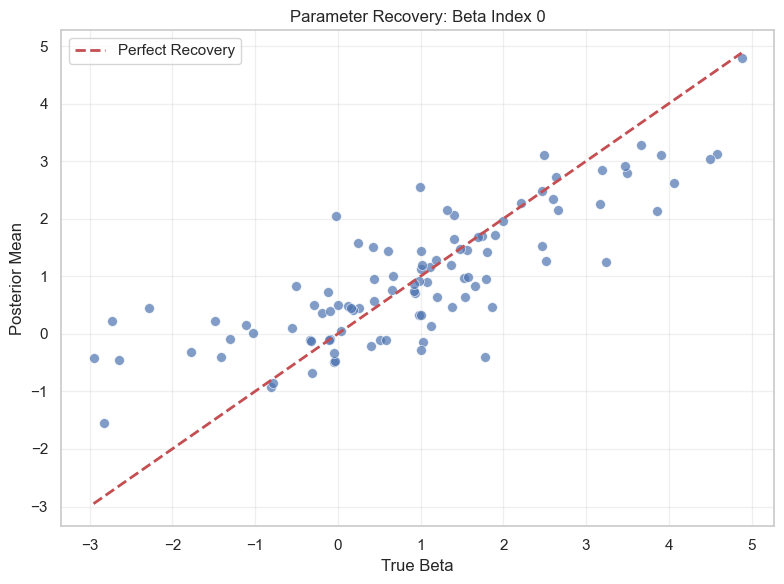

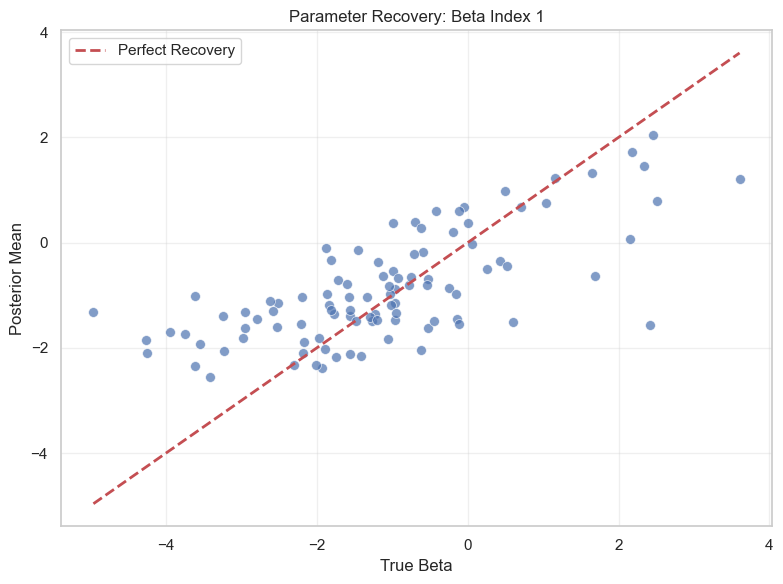

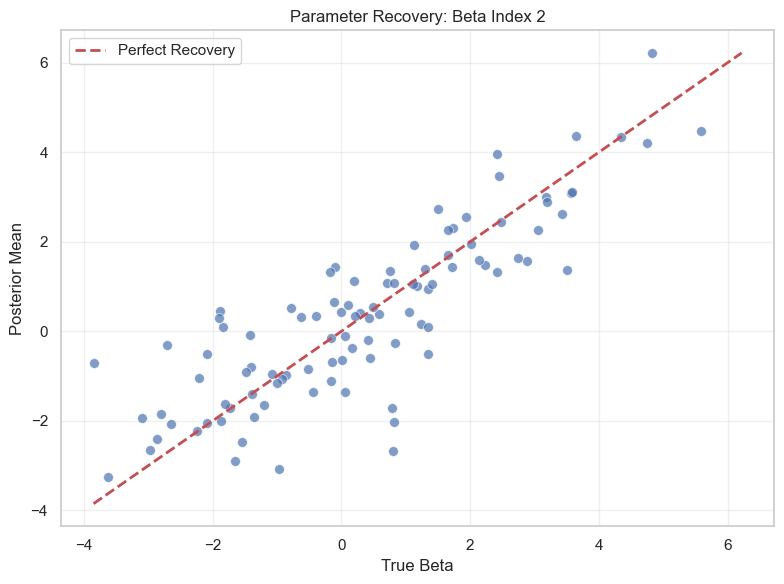

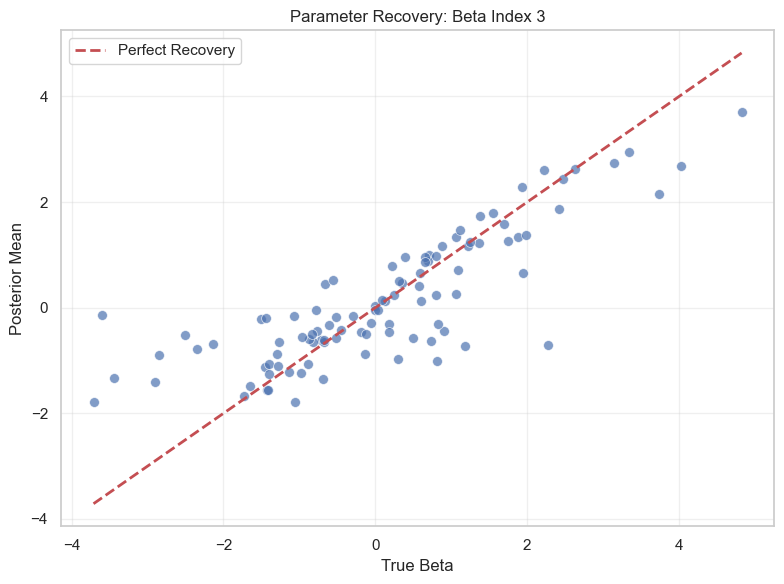

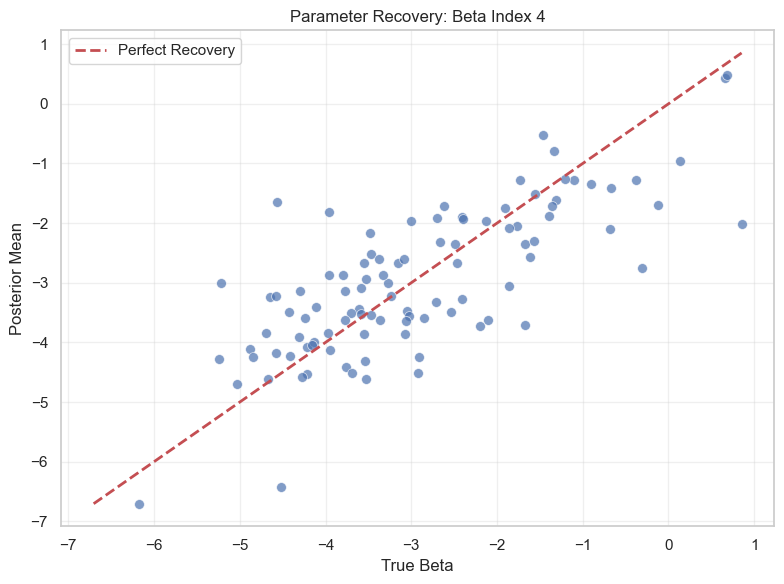


--- 3.2: Recovery Quality Metrics (RMSE & Correlation) ---
Parameter 0: RMSE=0.9636, Correlation=0.8132
Parameter 1: RMSE=1.1769, Correlation=0.7100
Parameter 2: RMSE=1.0950, Correlation=0.8460
Parameter 3: RMSE=0.9005, Correlation=0.8316
Parameter 4: RMSE=0.9507, Correlation=0.7583


In [11]:
# ==============================================================================
# 3. PARAMETER RECOVERY (If Ground Truth Available)
# ==============================================================================
print("\n" + "=" * 80)
print("3. PARAMETER RECOVERY")
print("=" * 80)

if "true_betas" in data:
    print("\n--- 3.1: Unit-Level Parameter Recovery (All Parameters) ---")
    for param_idx in range(n_params):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=data["true_betas"][:, param_idx],
            y=beta_posterior_means[:, param_idx],
            alpha=0.7,
            s=50
        )
        
        # Identity line
        min_val = min(data["true_betas"][:, param_idx].min(), 
                     beta_posterior_means[:, param_idx].min())
        max_val = max(data["true_betas"][:, param_idx].max(), 
                     beta_posterior_means[:, param_idx].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', 
                linewidth=2, label="Perfect Recovery")
        
        plt.xlabel("True Beta")
        plt.ylabel("Posterior Mean")
        plt.title(f"Parameter Recovery: Beta Index {param_idx}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Compute recovery quality metrics
    print("\n--- 3.2: Recovery Quality Metrics (RMSE & Correlation) ---")
    for param_idx in range(n_params):
        true_vals = data["true_betas"][:, param_idx]
        est_vals = beta_posterior_means[:, param_idx]
        rmse = np.sqrt(np.mean((true_vals - est_vals) ** 2))
        corr = np.corrcoef(true_vals, est_vals)[0, 1]
        print(f"Parameter {param_idx}: RMSE={rmse:.4f}, Correlation={corr:.4f}")


4. UNIT-LEVEL BETA POSTERIOR DISTRIBUTIONS

--- 4.2: Boxplots (Posterior Ranges) ---


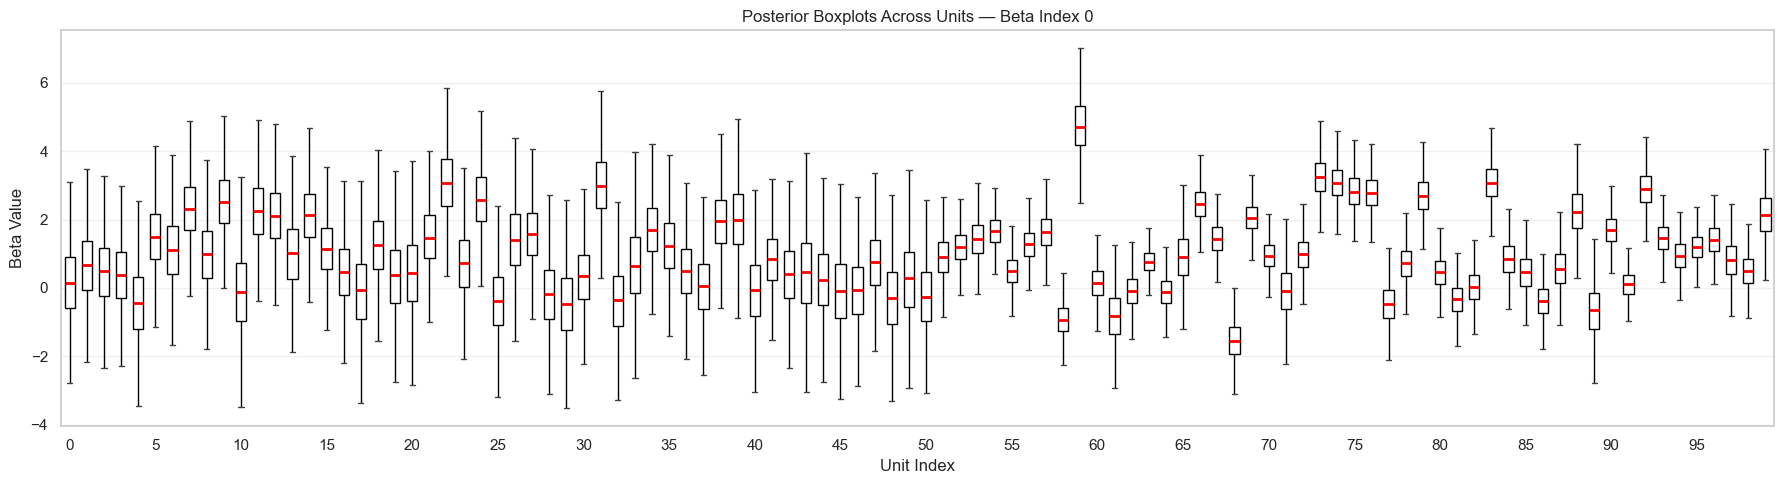

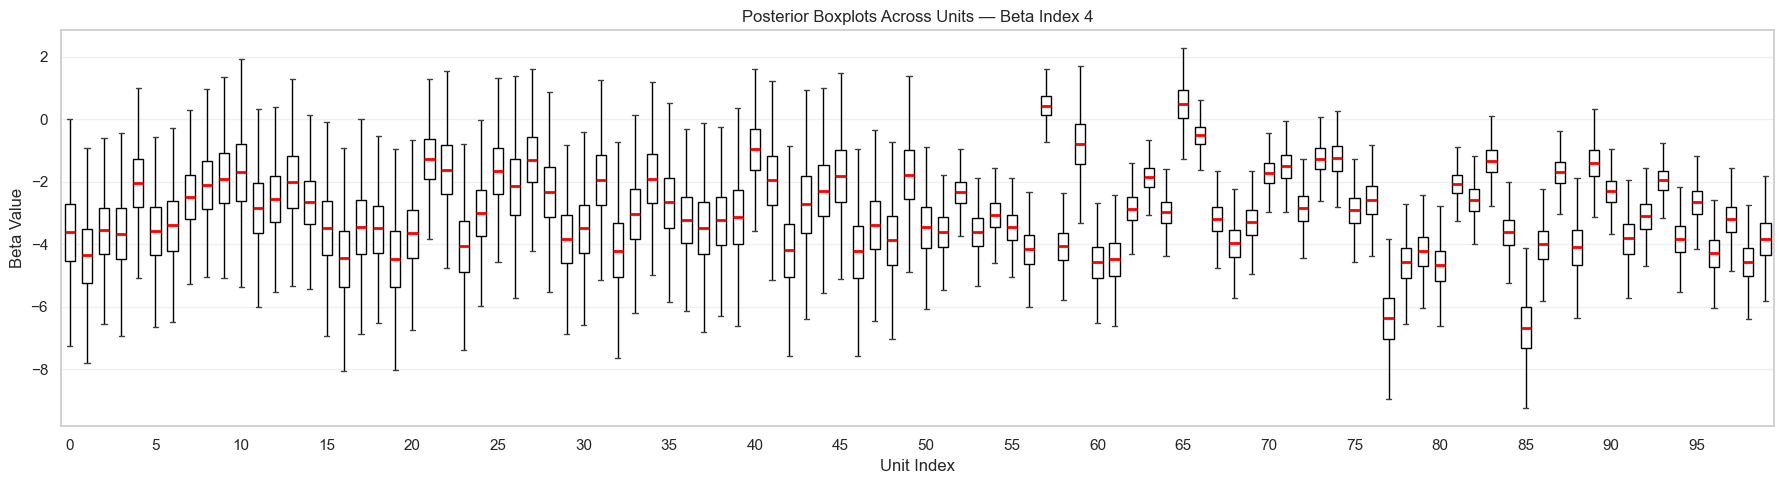


--- 4.3: Faceted Posterior Distributions per Unit (Selected Parameters) ---


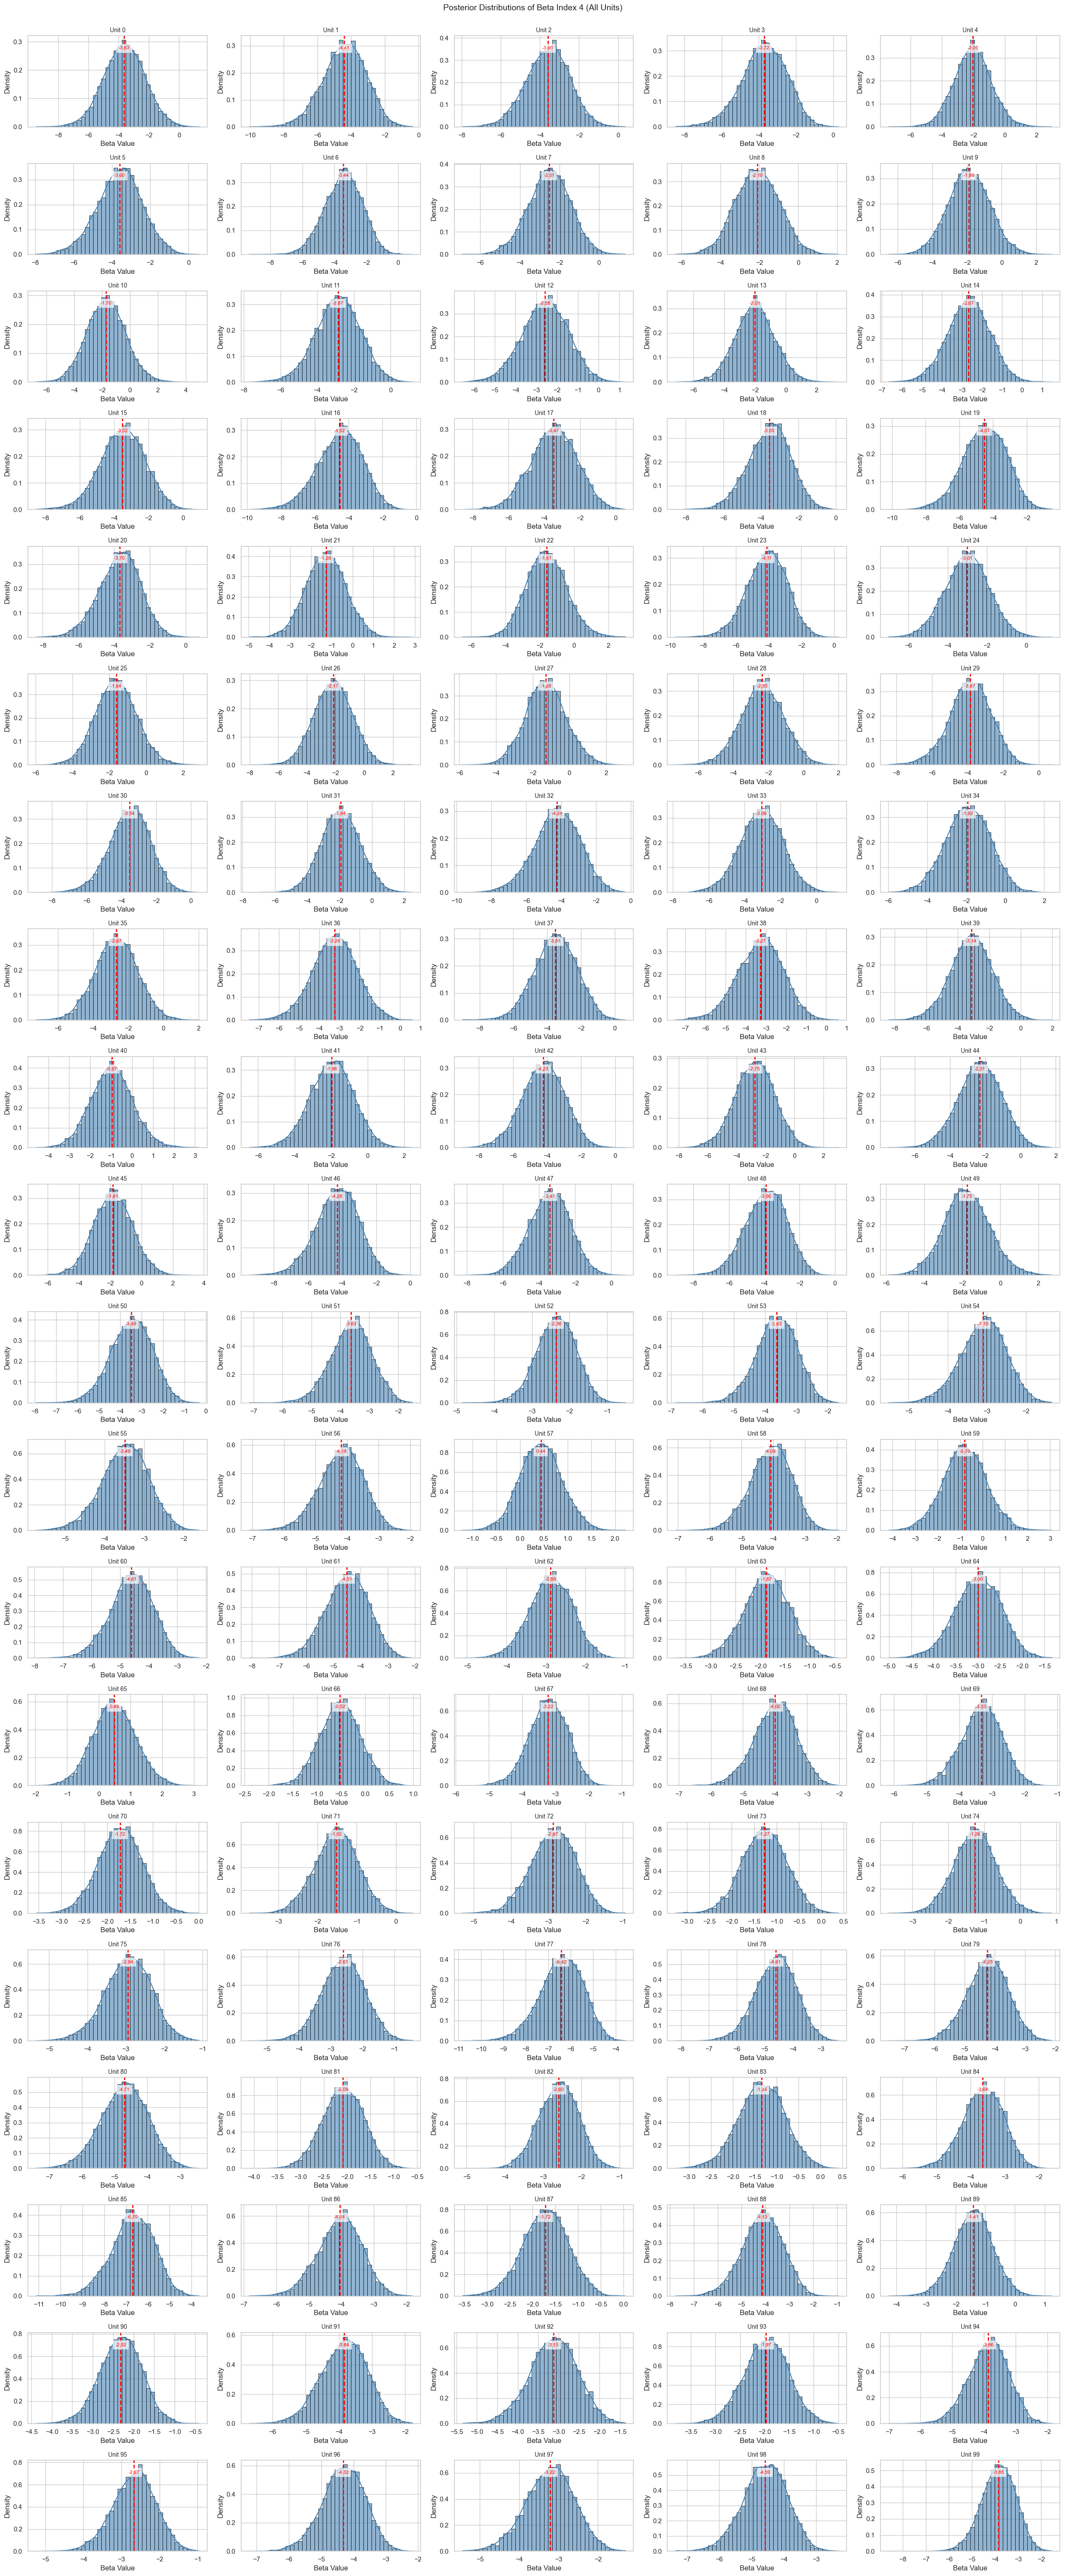

In [12]:
# ==============================================================================
# 4. UNIT-LEVEL BETA POSTERIOR DISTRIBUTIONS
# ==============================================================================
print("\n" + "=" * 80)
print("4. UNIT-LEVEL BETA POSTERIOR DISTRIBUTIONS")
print("=" * 80)

# Boxplots
print("\n--- 4.2: Boxplots (Posterior Ranges) ---")
def plot_unit_betas_boxplot(samples, params=None, figsize=(18, 5)):
    chains, n_samples, n_units, n_params_total = samples.shape
    if params is None:
        params = list(range(n_params_total))
    for param_idx in params:
        traces = samples[..., :, param_idx]
        traces_2d = traces.reshape(-1, n_units)
        
        plt.figure(figsize=figsize)
        sns.boxplot(
            data=traces_2d,
            color="white",
            showcaps=True,
            boxprops={'facecolor': 'white', 'edgecolor': 'black'},
            whiskerprops={'color': 'black'},
            medianprops={'color': 'red', 'linewidth': 2},
            showfliers=False,
            width=0.6
        )
        plt.xticks(range(0, n_units, 5))
        plt.title(f"Posterior Boxplots Across Units — Beta Index {param_idx}")
        plt.xlabel("Unit Index")
        plt.ylabel("Beta Value")
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()

plot_unit_betas_boxplot(samples["beta_i"], params=[0, 4])  # Intercept and Price Slope

# Faceted histograms with KDE for parameter list (langer runtime)
print("\n--- 4.3: Faceted Posterior Distributions per Unit (Selected Parameters) ---")
def plot_unit_beta_distributions(samples_dict, beta_index, bins=40):
    """
    Faceted histograms with KDE for all units, focusing on one beta index.
    """
    beta_samples = samples_dict["beta_i"]  # (chains, draws, units, betas)
    n_units = beta_samples.shape[2]
    
    # Flatten chains and draws → (units, posterior_samples)
    flat = beta_samples[..., :, beta_index].reshape(-1, n_units).T
    
    ncols = 5
    nrows = int(np.ceil(n_units / ncols))
    plt.figure(figsize=(5 * ncols, 3 * nrows))
    
    for unit in range(n_units):
        unit_samples = flat[unit]
        mean_val = np.mean(unit_samples)
        
        ax = plt.subplot(nrows, ncols, unit + 1)
        sns.histplot(unit_samples, bins=bins, kde=True, stat="density", 
                    alpha=0.6, color="steelblue", edgecolor="black")
        
        # Mean line
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2)
        ax.text(mean_val, ax.get_ylim()[1] * 0.85,
               f"{mean_val:.2f}", color="red", ha="center", fontsize=8,
               bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
        
        ax.set_title(f"Unit {unit}", fontsize=10)
        ax.set_xlabel("Beta Value")
        ax.set_ylabel("Density")
    
    plt.suptitle(f"Posterior Distributions of Beta Index {beta_index} (All Units)",
                fontsize=14, y=1.00)
    plt.tight_layout()
    plt.show()

# Plot for key parameters
for param_idx in [4]:  # simply price slope
    plot_unit_beta_distributions(samples, param_idx)


5. OVERLAID POSTERIOR DISTRIBUTIONS (All Units in One Plot)


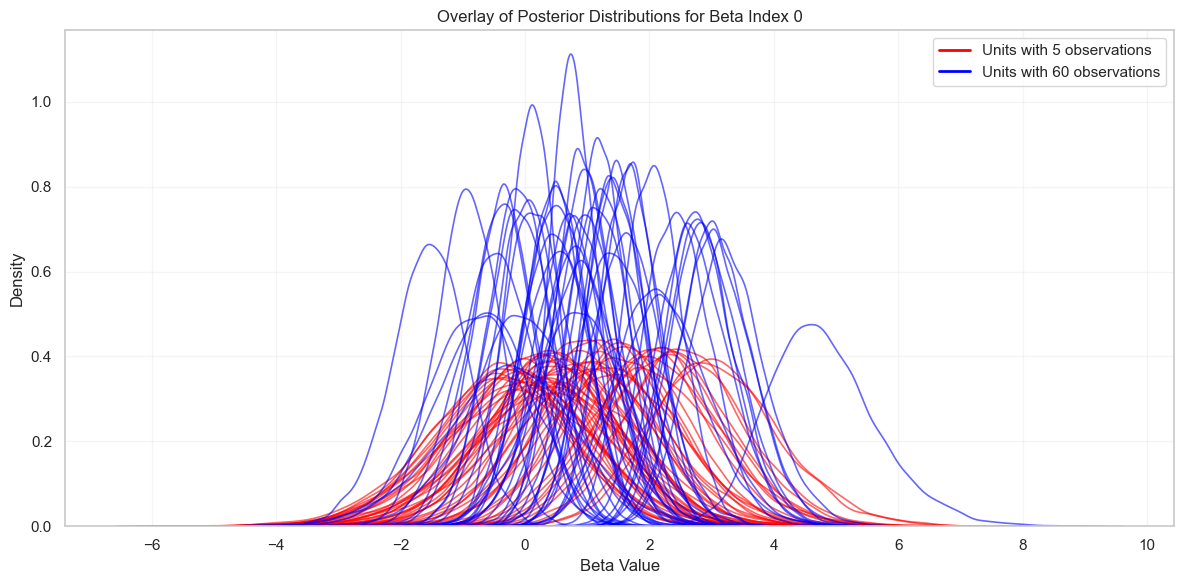

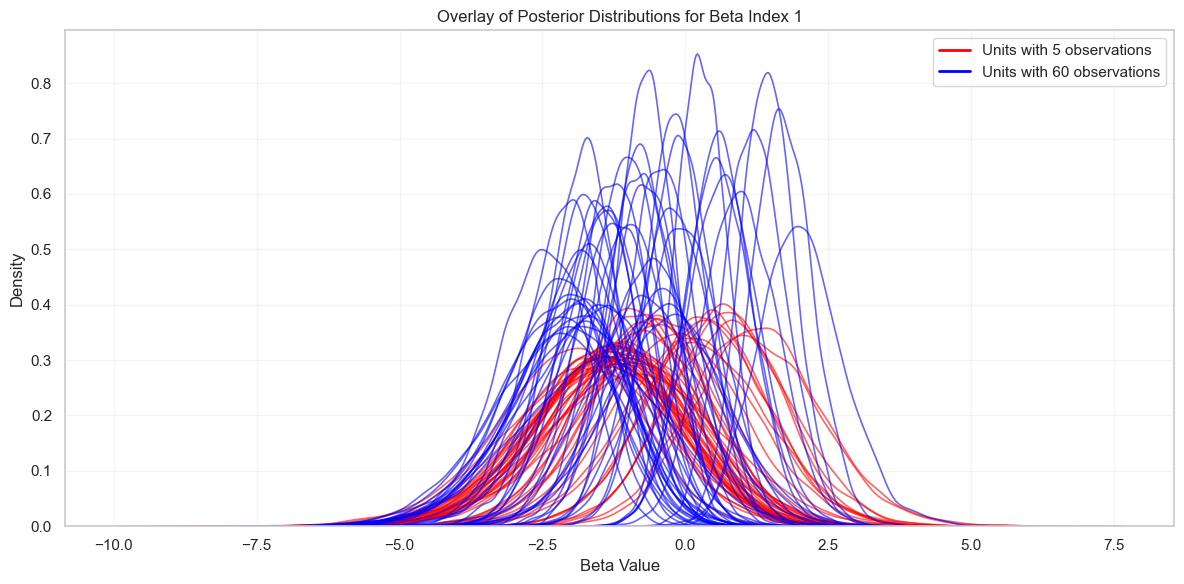

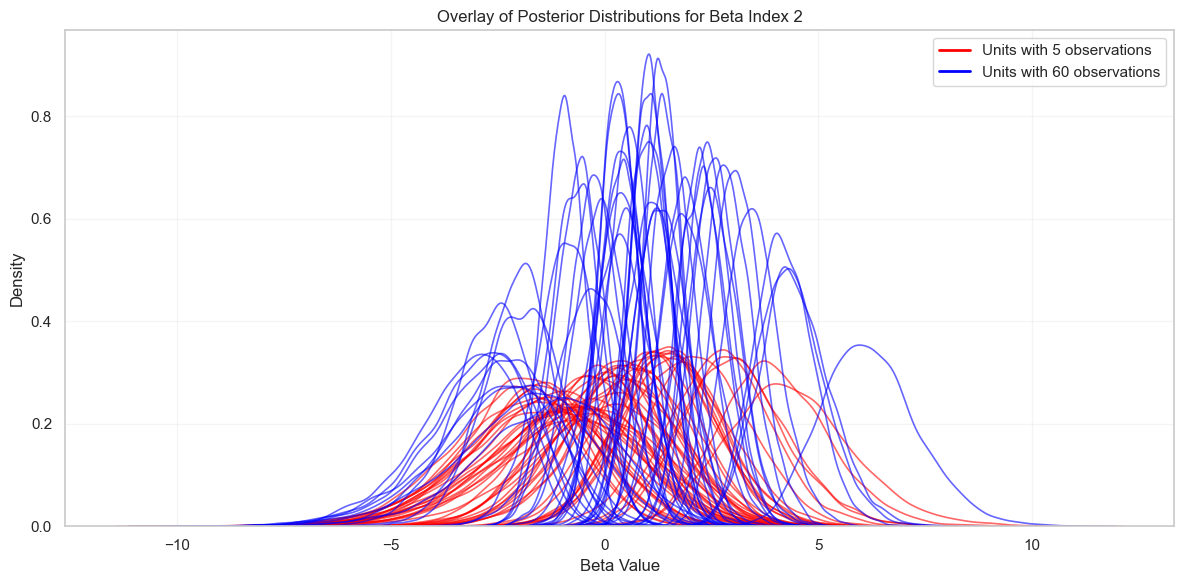

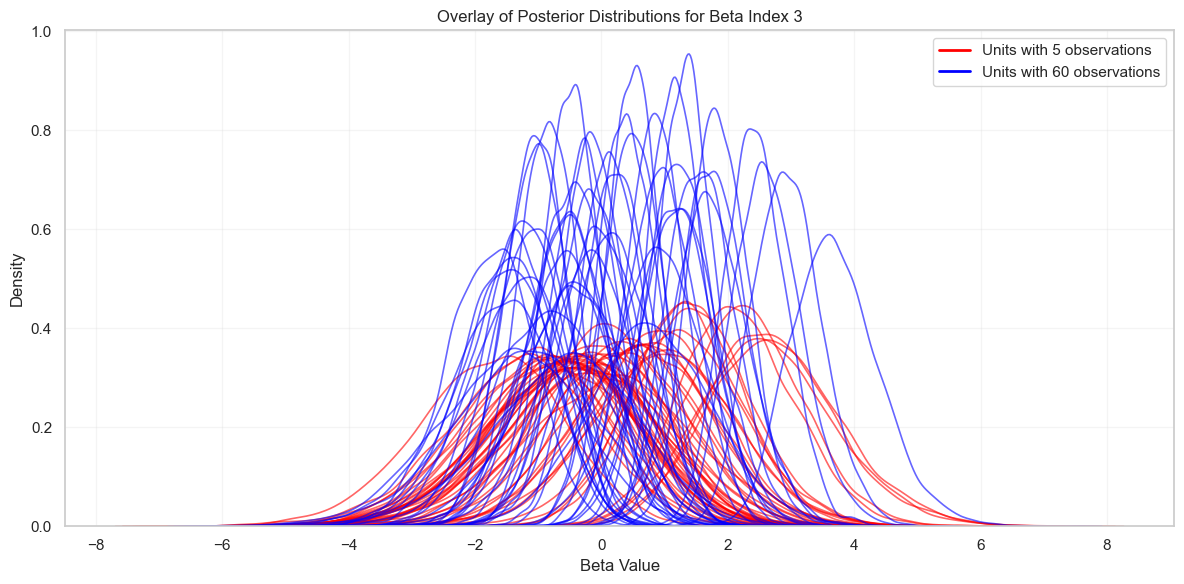

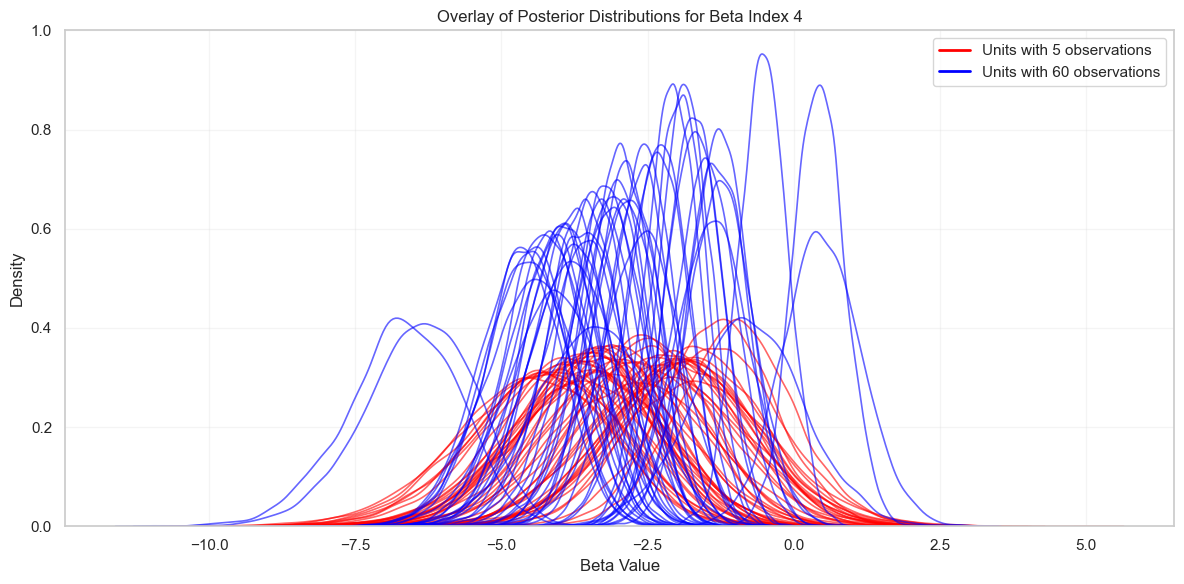

In [13]:
# ==============================================================================
# 5. OVERLAID POSTERIOR DISTRIBUTIONS
# ==============================================================================
print("\n" + "=" * 80)
print("5. OVERLAID POSTERIOR DISTRIBUTIONS (All Units in One Plot)")
print("=" * 80)

def plot_all_units_overlay(samples_dict, beta_index):
    """
    KDE overlay plot for all units, color-coded by data availability.
    """
    beta = samples_dict["beta_i"]  # (chains, draws, units, betas)
    n_units = beta.shape[2]
    
    # Flatten (chains * draws) for each unit
    flat = beta[..., :, beta_index].reshape(-1, n_units).T
    
    plt.figure(figsize=(12, 6))
    for unit in range(n_units):
        # Color by data availability (example: first 50 units = 5 obs, rest = 60 obs)
        color = "red" if unit < 50 else "blue"
        sns.kdeplot(flat[unit], linewidth=1.2, color=color, alpha=0.6)
    
    # Legend
    plt.plot([], [], color="red", linewidth=2, label="Units with 5 observations")
    plt.plot([], [], color="blue", linewidth=2, label="Units with 60 observations")
    plt.legend(fontsize=11)
    
    plt.title(f"Overlay of Posterior Distributions for Beta Index {beta_index}")
    plt.xlabel("Beta Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

for param_idx in range(n_params):
    plot_all_units_overlay(samples, param_idx)


6. GLOBAL MU POSTERIOR DISTRIBUTIONS
Mu posterior overlays for all parameters:


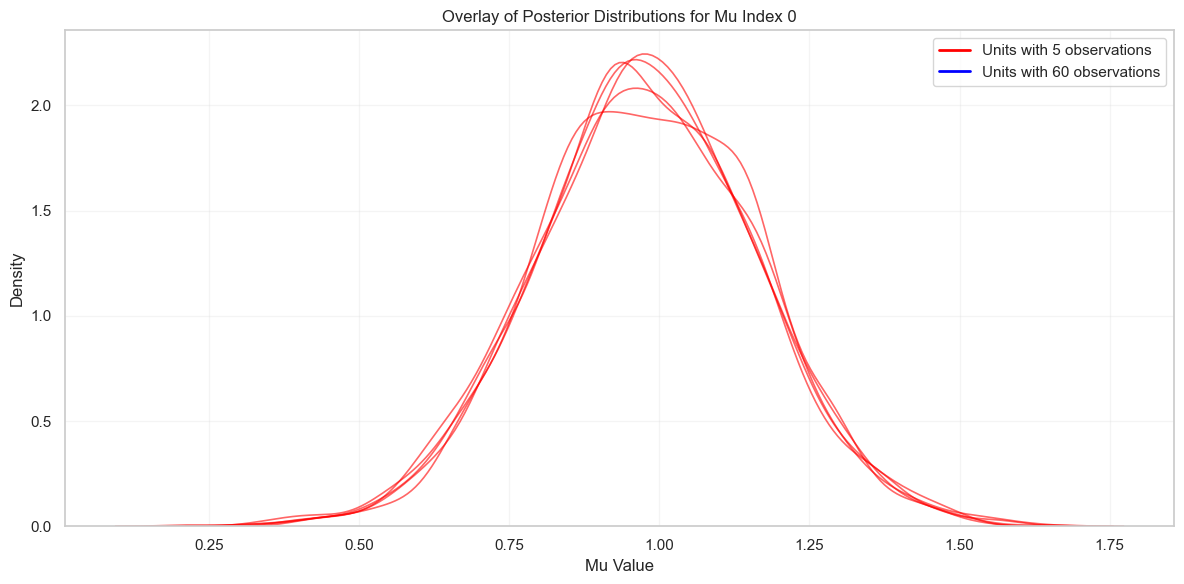

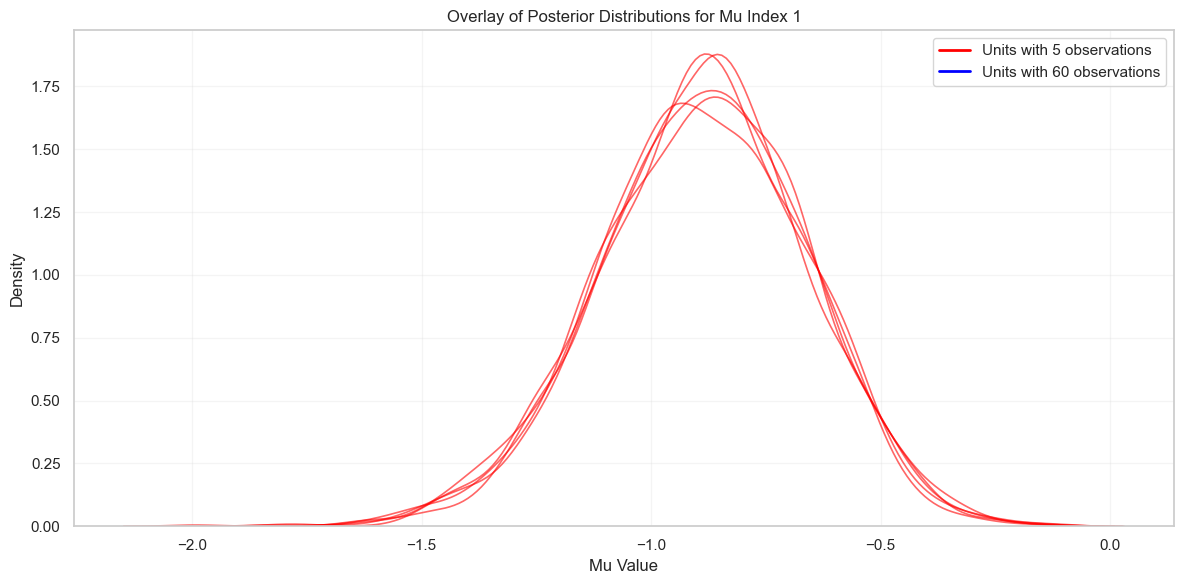

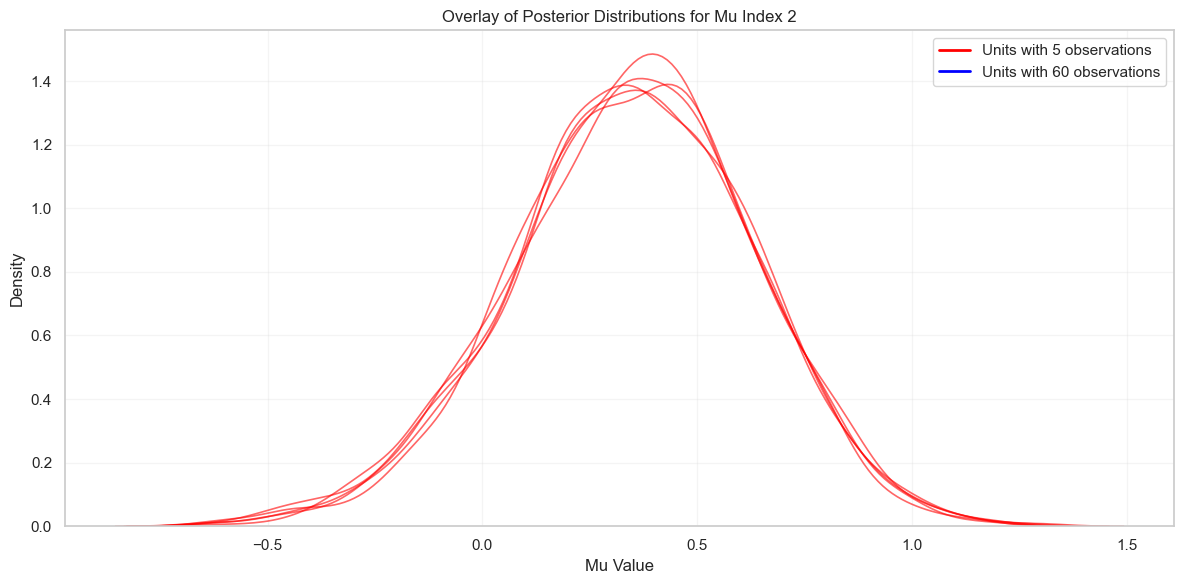

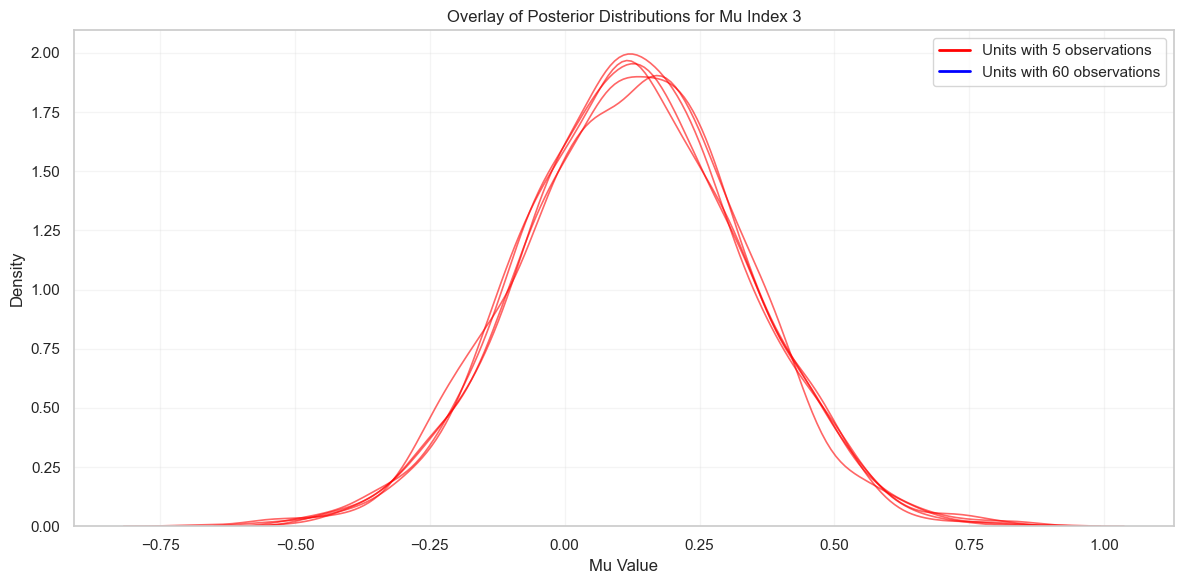

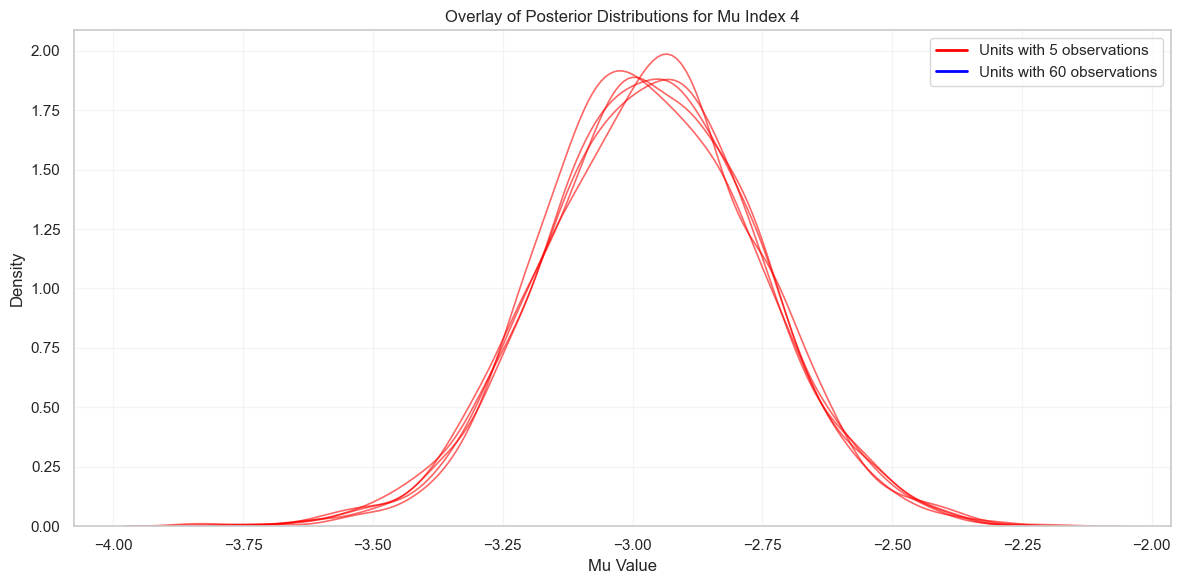

In [14]:
# ==============================================================================
# 6. GLOBAL MU POSTERIOR DISTRIBUTIONS
# ==============================================================================
print("\n" + "=" * 80)
print("6. GLOBAL MU POSTERIOR DISTRIBUTIONS")
print("=" * 80)

def plot_all_units_overlay_mu(samples_dict, mu_index):
    """
    KDE overlay for mu parameters across all units.
    """
    mu = samples_dict["mu"]  # (chains, draws, units, mus)
    n_units = mu.shape[2]
    
    flat = mu[..., :, mu_index].reshape(-1, n_units).T
    
    plt.figure(figsize=(12, 6))
    for unit in range(n_units):
        color = "red" if unit < 50 else "blue"
        sns.kdeplot(flat[unit], linewidth=1.2, color=color, alpha=0.6)
    
    plt.plot([], [], color="red", linewidth=2, label="Units with 5 observations")
    plt.plot([], [], color="blue", linewidth=2, label="Units with 60 observations")
    plt.legend(fontsize=11)
    
    plt.title(f"Overlay of Posterior Distributions for Mu Index {mu_index}")
    plt.xlabel("Mu Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

print("Mu posterior overlays for all parameters:")
for mu_index in range(n_params):
    plot_all_units_overlay_mu(samples, mu_index)


7. COMBINED POSTERIOR DISTRIBUTIONS

--- 7.1: All Beta Indices (Pooled Across Units) ---


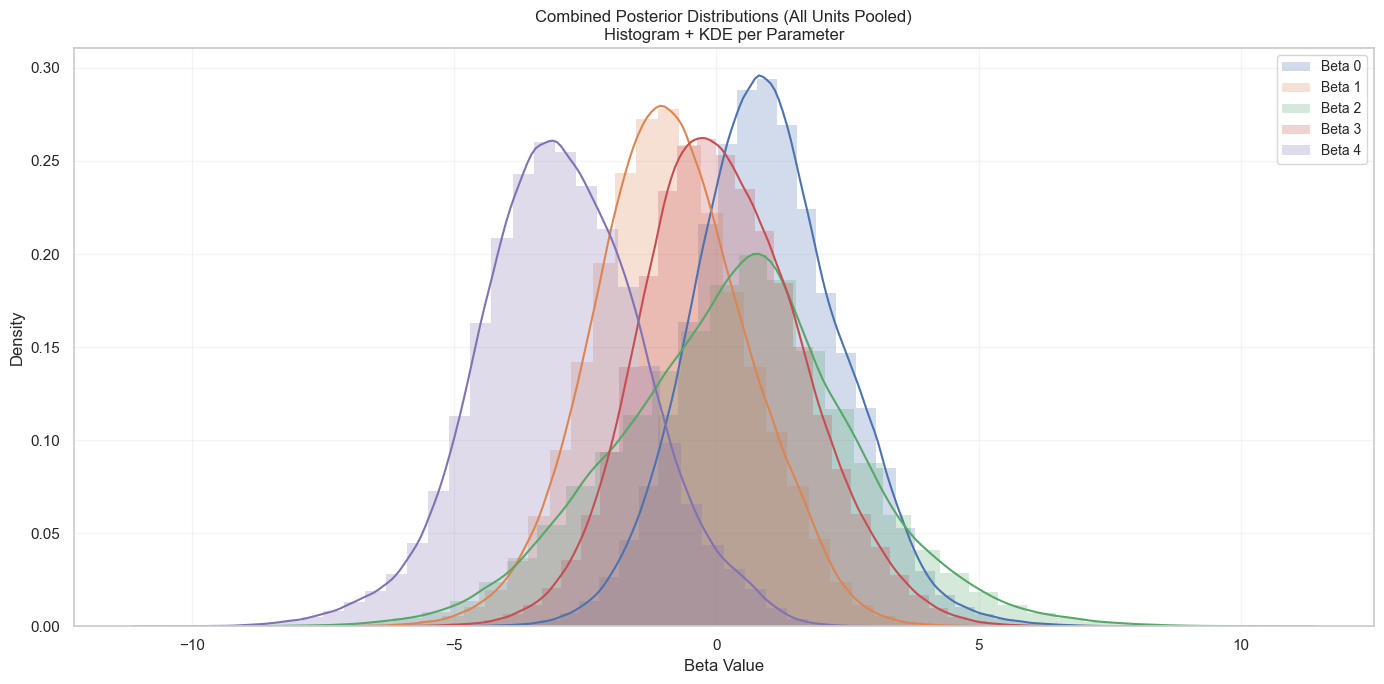


--- 7.2: Individual Beta Parameters (Pooled Across Units) ---


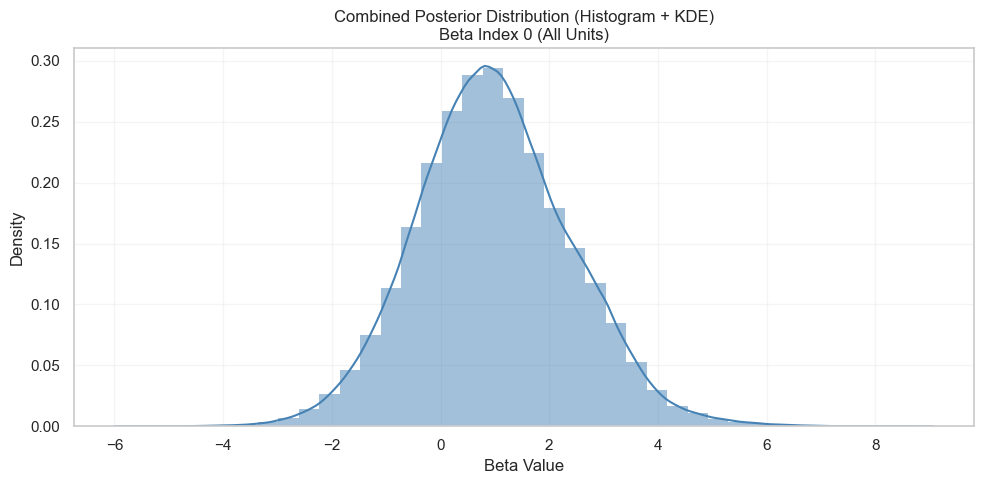

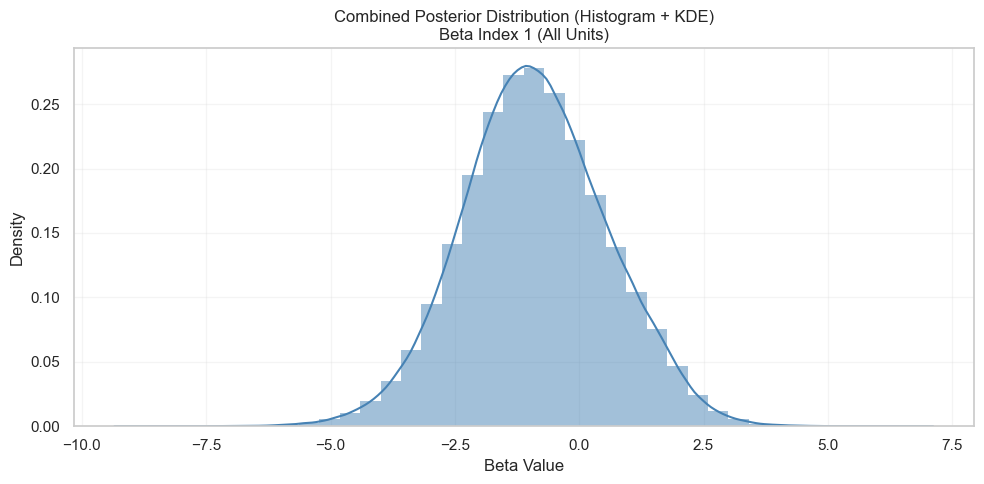

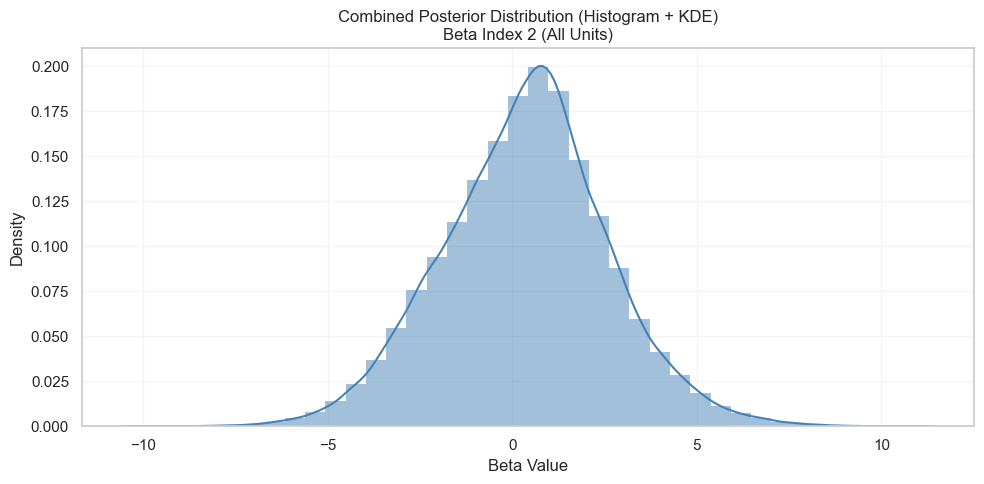

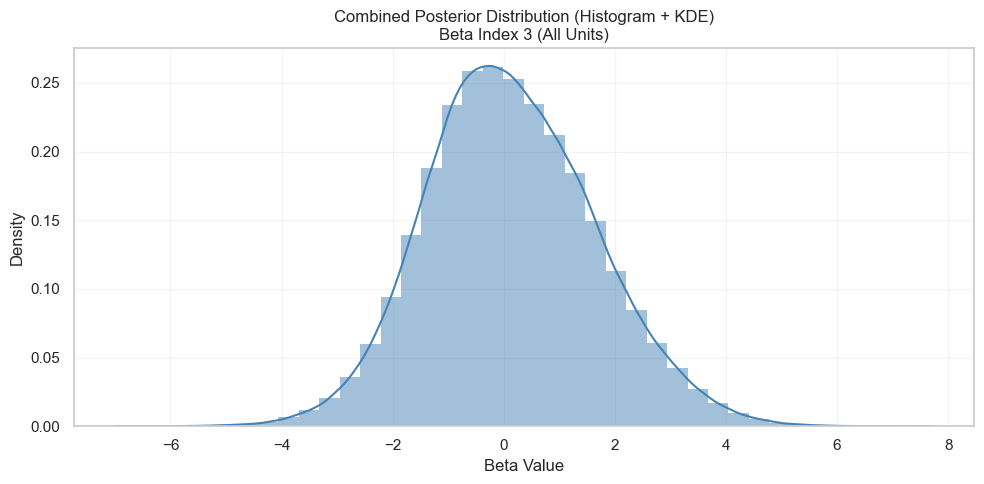

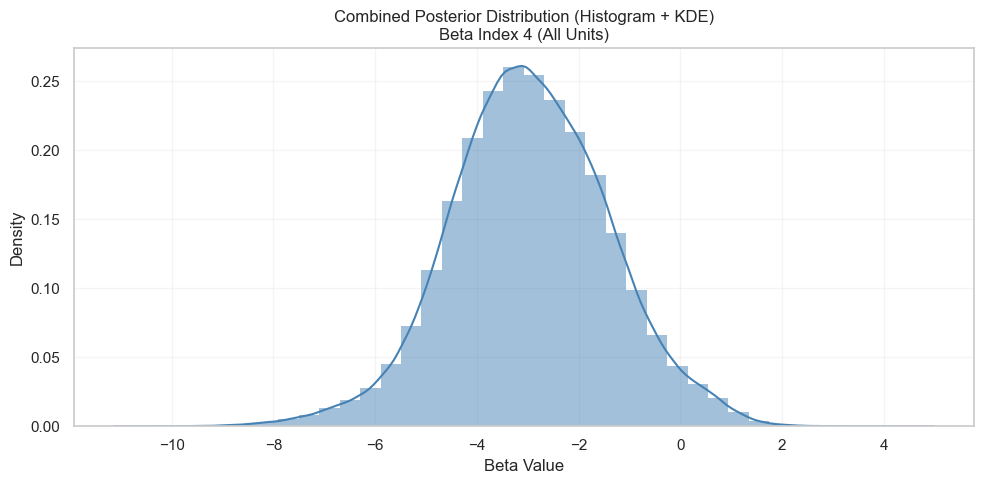

In [15]:
# ==============================================================================
# 7. COMBINED POSTERIOR DISTRIBUTIONS (Pooled Across All Units)
# ==============================================================================
print("\n" + "=" * 80)
print("7. COMBINED POSTERIOR DISTRIBUTIONS")
print("=" * 80)

# --- 7.1 All betas combined in one plot ---
print("\n--- 7.1: All Beta Indices (Pooled Across Units) ---")
def plot_all_betas_combined_hist_kde(samples_dict, beta_indices=None, bins=40):
    """
    Pool all beta samples across chains, draws, and units for each parameter.
    """
    if beta_indices is None:
        beta_indices = range(samples_dict["beta_i"].shape[3])
    
    beta = samples_dict["beta_i"]  # (chains, draws, units, betas)
    
    plt.figure(figsize=(14, 7))
    for b in beta_indices:
        arr = beta[..., b].reshape(-1)  # Flatten everything
        sns.histplot(arr, bins=bins, kde=True, stat="density",
                    alpha=0.25, linewidth=0, label=f"Beta {b}")
    
    plt.title("Combined Posterior Distributions (All Units Pooled)\nHistogram + KDE per Parameter")
    plt.xlabel("Beta Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

plot_all_betas_combined_hist_kde(samples)

# --- 7.2 Individual parameter pooled distributions ---
print("\n--- 7.2: Individual Beta Parameters (Pooled Across Units) ---")
def plot_combined_beta_hist_kde(samples_dict, beta_index, bins=40):
    """
    Histogram + KDE for a single beta index, pooled across all units.
    """
    beta = samples_dict["beta_i"]
    arr = beta[..., beta_index].reshape(-1)  # Flatten everything
    
    plt.figure(figsize=(10, 5))
    sns.histplot(arr, bins=bins, kde=True, stat="density",
                linewidth=0, alpha=0.5, color="steelblue")
    
    plt.title(f"Combined Posterior Distribution (Histogram + KDE)\nBeta Index {beta_index} (All Units)")
    plt.xlabel("Beta Value")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

for param_idx in range(n_params):
    plot_combined_beta_hist_kde(samples, param_idx)

In [16]:
# ==============================================================================
# 8. SUMMARY TABLE
# ==============================================================================
print("\n" + "=" * 80)
print("8. SUMMARY TABLE: Selected Units")
print("=" * 80)

selected_units = [0, 1, 2]
for unit_idx in selected_units:
    print(f"\n--- Unit {unit_idx} ---")
    for param_idx in range(n_params):
        mean = beta_posterior_means[unit_idx, param_idx]
        std = beta_posterior_stds[unit_idx, param_idx]
        print(f"  Beta[{param_idx}]: μ={mean:8.4f}, σ={std:8.4f}")



8. SUMMARY TABLE: Selected Units

--- Unit 0 ---
  Beta[0]: μ=  0.1446, σ=  1.1059
  Beta[1]: μ= -1.1828, σ=  1.2978
  Beta[2]: μ=  1.4738, σ=  1.1226
  Beta[3]: μ= -0.4469, σ=  1.2251
  Beta[4]: μ= -3.6313, σ=  1.3541

--- Unit 1 ---
  Beta[0]: μ=  0.6447, σ=  1.0603
  Beta[1]: μ=  0.3730, σ=  1.0649
  Beta[2]: μ= -0.7889, σ=  1.6930
  Beta[3]: μ= -1.3227, σ=  1.2097
  Beta[4]: μ= -4.4057, σ=  1.2801

--- Unit 2 ---
  Beta[0]: μ=  0.4693, σ=  1.0709
  Beta[1]: μ= -0.5465, σ=  1.0764
  Beta[2]: μ=  1.5705, σ=  1.2008
  Beta[3]: μ=  0.4606, σ=  1.0806
  Beta[4]: μ= -3.5953, σ=  1.1070
